Resolução deafio clustering, Gustavo Alves

Dataset:  Student Habits vs Academic Performance (link: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance/data)

Importando as bibliotecas utilisadas na análise:

In [628]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

---

1) Observação dos dados e formulação de hipóteses:

Vamos olhar como nosso dataset se parece:

In [629]:
df = pd.read_csv('archive/student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [630]:
df.shape

(1000, 16)

Temos um dataset de estudantes que lista dados com enfoque nos seus hábitos, como dieta e frequência de exercício, dados pessoais, como idade e gênero, e na nota de um exame. No total, temos 1000 estudantes, cada estudante avaliado de acordo com as seguintes variáveis:

1) Numéricas contínuas: horas diárias estudadas, horás diárias em redes sociais, horas diárias na Netflix, porcentagem de presença, horas diárias de sono, nota no exame;

2) Numéricas discretas: idade, frequência de exercício, qualidade de saúde mental;

3) Não numéricas: gênero, trabalho meio período, qualidade da dieta, nível de educação dos pais, qualidade da internet e participação extracurricular.

Hipótese:

 Á primeira vista, é possível pensar em dois pilares de classificação: saúde(qualidade da dieta, sono, exercício, saúde mental, ...) e performance(horas de estudo diário, participação em atividades extracurriculares, nota exame, ...). Intuitivamente, saúde e performance são áreas correlatas, então deve ser possível estabelecer uma classificação que relacione todos esses dados. Porém, é difícil estimar uma quantidade de grupos e um único critério utilizado para unir essas duas áreas. Caso fossemos pensar somente em performance poderíamos ter poucos clusters como [bom, médio, ruim], assim como em saúde [boa, média ruim], mas juntar os dois de modo que tenhamos separações significativas de grupos não é trivial.

 Sobre os dados, imagino que no contexto da performance as métricas mais importantes para separação desses grupos serão o nível de educação dos pais, porque a criação tem uma importância grande, e o número de horas estudadas diariamente. No contexto dos hábitos, sono e exercício devem ser as mais importantes.

 Por fim, imagino que na separação dos grupos, usando as métricas citadas como mais importantes para visualizar, a separação deles será evidente.

---

2) EDA

Primeiramente, vamos analisar se temos dados faltantes.

In [631]:
df.isna().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

Temos 91 dados faltantes de uma categoria que pela minha hipótese, deve ter uma relação grande com outras variáveis. Para confirmar isso, vou transformar nosso dataframe em um numérico, colocando números que façam sentido para categorias com hierarquia, e ver a correlação entre o nível de educação parental com as outras features.

Vamos ver os valores únicos dessas colunas:

In [632]:
for col in df.columns:
    if df[col].dtype == 'object' and col != 'student_id':
        print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male' 'Other']
part_time_job: ['No' 'Yes']
diet_quality: ['Fair' 'Good' 'Poor']
parental_education_level: ['Master' 'High School' 'Bachelor' nan]
internet_quality: ['Average' 'Poor' 'Good']
extracurricular_participation: ['Yes' 'No']


Percebe-se que a qualidade da dieta, o nível de educação dos pais e a qualidade da internet tem categorias hierárquicas, então vamos tratá-las substituindo por valores numéricos crescentes(0,1,2).

In [633]:
map_dieta = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2
}

map_educ = {
    'High School': 0,
    'Bachelor': 1,
    'Master': 2
}

map_internet = {
    'Poor': 0,
    'Average': 1,
    'Good': 2
}

df_numeric = df.copy()
df_numeric.drop('student_id', axis=1, inplace=True)

df_numeric['diet_quality'] = df_numeric['diet_quality'].map(map_dieta)
df_numeric['parental_education_level'] = df_numeric['parental_education_level'].map(map_educ)
df_numeric['internet_quality'] = df_numeric['internet_quality'].map(map_internet)

df_numeric.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,1,6,2.0,1,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,2,6,0.0,1,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,0,1,0.0,0,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,0,4,2.0,2,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,1,3,2.0,2,1,No,66.4


Agora que eu troquei as categorias com hierarquia, vou usar o LabelEncoder() para aquelas que não tem uma relação de hierarquia:

In [634]:
for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        encoder = LabelEncoder()
        df_numeric[col] = encoder.fit_transform(df_numeric[col])

df_numeric.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,0,0.0,1.2,1.1,0,85.0,8.0,1,6,2.0,1,8,1,56.2
1,20,0,6.9,2.8,2.3,0,97.3,4.6,2,6,0.0,1,8,0,100.0
2,21,1,1.4,3.1,1.3,0,94.8,8.0,0,1,0.0,0,1,0,34.3
3,23,0,1.0,3.9,1.0,0,71.0,9.2,0,4,2.0,2,1,1,26.8
4,19,0,5.0,4.4,0.5,0,90.9,4.9,1,3,2.0,2,1,0,66.4


Vamos ver se nossa substituição está correta vendo os máximos e mínimos das features substituídas:

In [635]:
df_numeric.describe()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,909.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.752475,1.285000,5.438000,0.318000,69.601500
std,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.744515,0.726845,2.847501,0.465932,16.888564
min,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


Perfeito, agora vamos calcular as correlações:

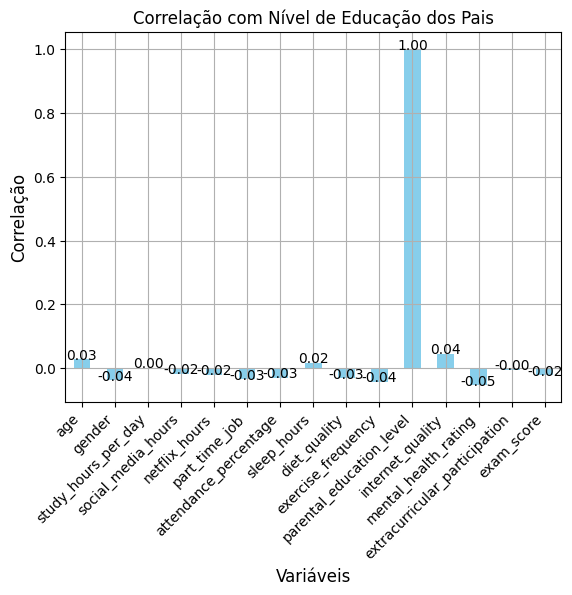

In [636]:
correlacao = df_numeric.corr()[['parental_education_level']]
correlacao.plot(kind='bar', color='skyblue', legend=False)
plt.title('Correlação com Nível de Educação dos Pais')
plt.xlabel('Variáveis', fontsize=12)
plt.ylabel('Correlação', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
for i, valor in enumerate(correlacao['parental_education_level']):
    plt.text(i, valor, f'{valor:.2f}',  ha='center')


Não tivemos nenhuma correlação forte detectada, todas com um módulo inferior a 0.05, o que não necessariamente indica que nossa hipótese estava errada, apenas que não há uma relação linear forte. Ccuriosamente, a feature com maior correlação considerando o módulo foi o nível de saúde mental, porém negativo, mas como dito a correlação é muito pequena para tirar conclusões. Vamos fazer uma análise mais estatística com 2 variáveis do contexto de performance e de natureza contínua, estudo diário e nota do exame: 

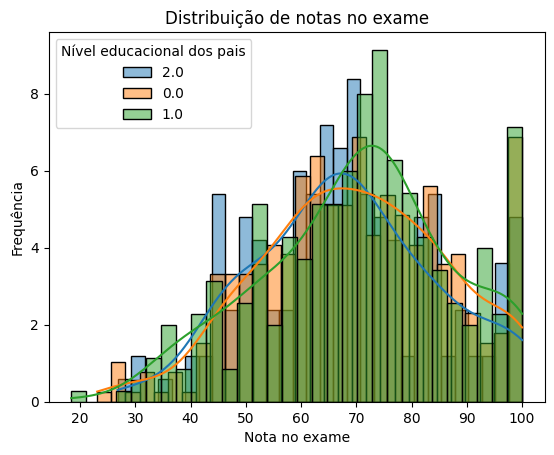

In [637]:
grupos = df_numeric['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_numeric[df_numeric['parental_education_level'] == grupo]['exam_score'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.legend(title='Nível educacional dos pais')

Temos 3 gráficos muito parecidos. Agora vamos ver o estudo diário:

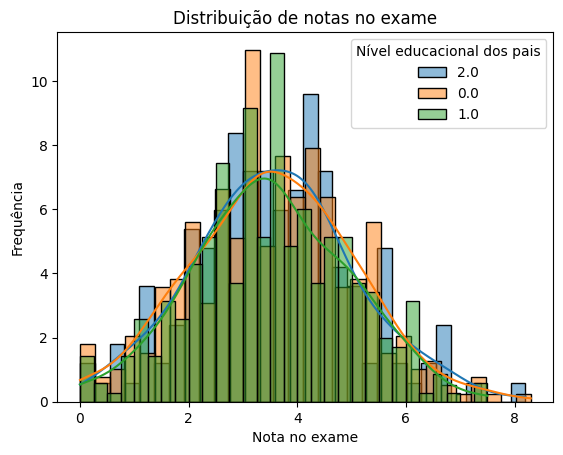

In [638]:
grupos = df_numeric['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_numeric[df_numeric['parental_education_level'] == grupo]['study_hours_per_day'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.legend(title='Nível educacional dos pais')

Outra amostra de gráficos muito parecida. O que podemos concluir é que talvez o nível de educação parental não seja tão relevante no contexto educacional, algo extremamente contraituitivo. Ainda assim, creio que mesmo não óbvia, há uma relação entre esses dados no contexto educacional, então não vou tratar com preenchimento da média ou da moda, e sim dos k-vizinhos mais próximos.

Para isso, utilizei o KNNImputer do sklearn, em conjunto com o StandardScaler para transformar meus dados para meu algoritmo lidar melhor com as distâncias. Após isso, criei um dataframe baseado no dataframe que foi preenchido os NaN revertendo a escala para melhor visualização.

In [639]:
escala = StandardScaler()
df_escala = escala.fit_transform(df_numeric)

imputer = KNNImputer(n_neighbors=7)
df_imputed = imputer.fit_transform(df_escala)

df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns)
df_revertido = escala.inverse_transform(df_imputed)
df_revertido = pd.DataFrame(df_revertido, columns=df_numeric.columns)

df_revertido.describe()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,0.561000,3.55010,2.505500,1.819700,2.150000e-01,84.131700,6.470100,1.19300,3.042000,7.527143e-01,1.285000,5.438000,0.318000,69.601500
std,2.3081,0.574987,1.46889,1.172422,1.075118,4.110279e-01,9.399246,1.226377,0.72545,2.025423,7.138228e-01,0.726845,2.847501,0.465932,16.888564
min,17.0000,0.000000,0.00000,0.000000,0.000000,-2.775558e-17,56.000000,3.200000,0.00000,0.000000,-1.110223e-16,0.000000,1.000000,0.000000,18.400000
25%,18.7500,0.000000,2.60000,1.700000,1.000000,-2.775558e-17,78.000000,5.600000,1.00000,1.000000,-1.110223e-16,1.000000,3.000000,0.000000,58.475000
50%,20.0000,1.000000,3.50000,2.500000,1.800000,-2.775558e-17,84.400000,6.500000,1.00000,3.000000,1.000000e+00,1.000000,5.000000,0.000000,70.500000
75%,23.0000,1.000000,4.50000,3.300000,2.525000,-2.775558e-17,91.025000,7.300000,2.00000,5.000000,1.000000e+00,2.000000,8.000000,1.000000,81.325000
max,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000e+00,100.000000,10.000000,2.00000,6.000000,2.000000e+00,2.000000,10.000000,1.000000,100.000000


O python não aproximou 2 das nossas features discretas(trabalho meio período e nível de educação parental) corretamente, então vamos consertar.

In [640]:
df_revertido['parental_education_level'] = df_revertido['parental_education_level'].round().astype(int)
df_revertido['part_time_job'] = df_revertido['part_time_job'].round().astype(int)

Verificando novamente:

In [641]:
df_revertido.describe()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.761000,1.285000,5.438000,0.318000,69.601500
std,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.718607,0.726845,2.847501,0.465932,16.888564
min,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


In [642]:
df_revertido.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23.0,0.0,0.0,1.2,1.1,0,85.0,8.0,1.0,6.0,2,1.0,8.0,1.0,56.2
1,20.0,0.0,6.9,2.8,2.3,0,97.3,4.6,2.0,6.0,0,1.0,8.0,0.0,100.0
2,21.0,1.0,1.4,3.1,1.3,0,94.8,8.0,0.0,1.0,0,0.0,1.0,0.0,34.3
3,23.0,0.0,1.0,3.9,1.0,0,71.0,9.2,0.0,4.0,2,2.0,1.0,1.0,26.8
4,19.0,0.0,5.0,4.4,0.5,0,90.9,4.9,1.0,3.0,2,2.0,1.0,0.0,66.4


Vamos ver se a distribuição do nível de educação parental se mantém:

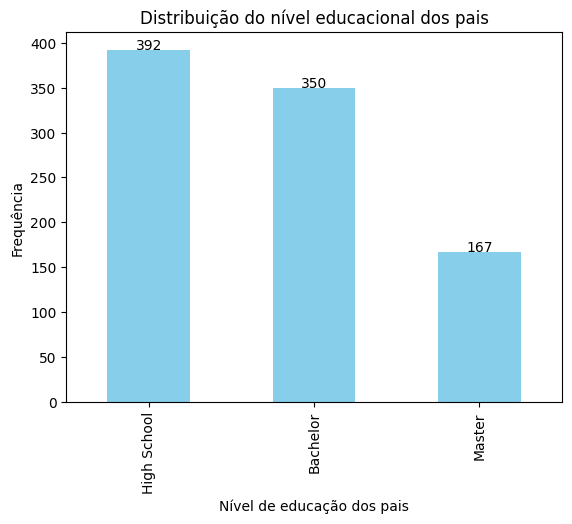

In [643]:
freq = df['parental_education_level'].value_counts()
freq.plot(kind='bar', color='skyblue', legend=False)
plt.title('Distribuição do nível educacional dos pais')
plt.xlabel('Nível de educação dos pais')
plt.ylabel('Frequência')

for i, valor in enumerate(freq):
    plt.text(i, valor, f'{valor}',  ha='center')

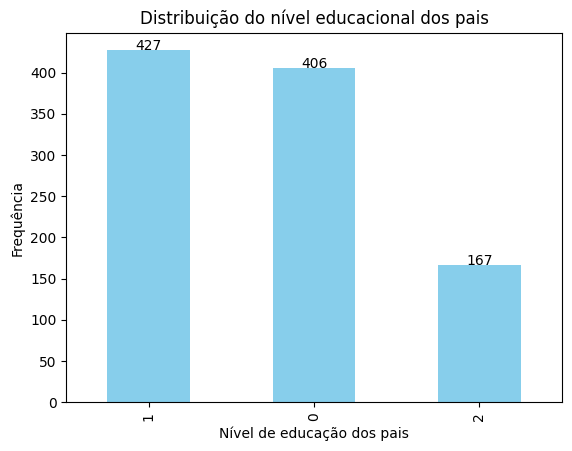

In [644]:
freq_revertido = df_revertido['parental_education_level'].value_counts()
freq_revertido.plot(kind='bar', color='skyblue', legend=False)
plt.title('Distribuição do nível educacional dos pais')
plt.xlabel('Nível de educação dos pais')
plt.ylabel('Frequência')

for i, valor in enumerate(freq_revertido):
    plt.text(i, valor, f'{valor}',  ha='center')

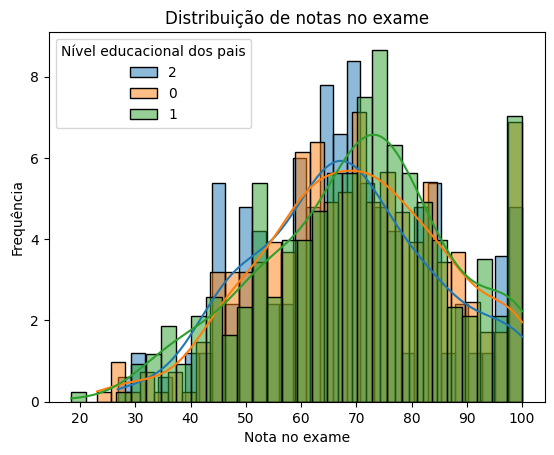

In [645]:
grupos = df_revertido['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_revertido[df_revertido['parental_education_level'] == grupo]['exam_score'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

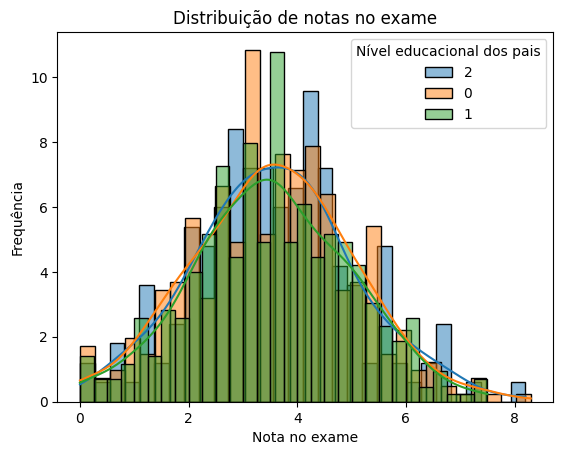

In [646]:
grupos = df_revertido['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_revertido[df_revertido['parental_education_level'] == grupo]['study_hours_per_day'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

Os gráficos de distribuição e a frequeência estão semelhantes, então vamos manter essa estratégia de preenchimento de dados.

Agora, vamos analisar se temos muitos outliers nos dados:

In [647]:
df_revertido.describe()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.761000,1.285000,5.438000,0.318000,69.601500
std,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.718607,0.726845,2.847501,0.465932,16.888564
min,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


Analisando por cima, não parece ter outliers significativos, nenhum desvio padrão está alto,todos os dados variam em um intervalo bem especificado. Pensando na classificação, podemos ter um outliner quando analisamos um certo grupo(exemplo: entre o grupo dos alunos que estudam menos de 2 horas por dia, um tirou uma nota acima de 90), mas fazer uma análise de todos esses grupos que podem ter outliers é algo inviável, até porque podemos fazer grupos de 2, 3, ... , variáveis, resultando em diversos grupos com possíveis outliers.

---

3) Revisão de hipóteses

Vamos gerar novamente nossas correlações, mas dessa vez para todas as variáveis, e ver as mais fortes:

Nota: print de 2 em 2 para evitar duplicata da correlação

In [648]:

correlacao = df_revertido.corr().abs().unstack() 
correlacao = correlacao[correlacao < 1]  
correlacao_ordenada = correlacao.sort_values(ascending=False)

for i in range(0, 20, 2):
    print(f"{correlacao_ordenada.index[i]}: {correlacao_ordenada.values[i]:.2f}")


('study_hours_per_day', 'exam_score'): 0.83
('mental_health_rating', 'exam_score'): 0.32
('exam_score', 'netflix_hours'): 0.17
('social_media_hours', 'exam_score'): 0.17
('exercise_frequency', 'exam_score'): 0.16
('sleep_hours', 'exam_score'): 0.12
('exam_score', 'attendance_percentage'): 0.09
('attendance_percentage', 'diet_quality'): 0.06
('parental_education_level', 'mental_health_rating'): 0.05
('exercise_frequency', 'gender'): 0.05


Correlação completa:

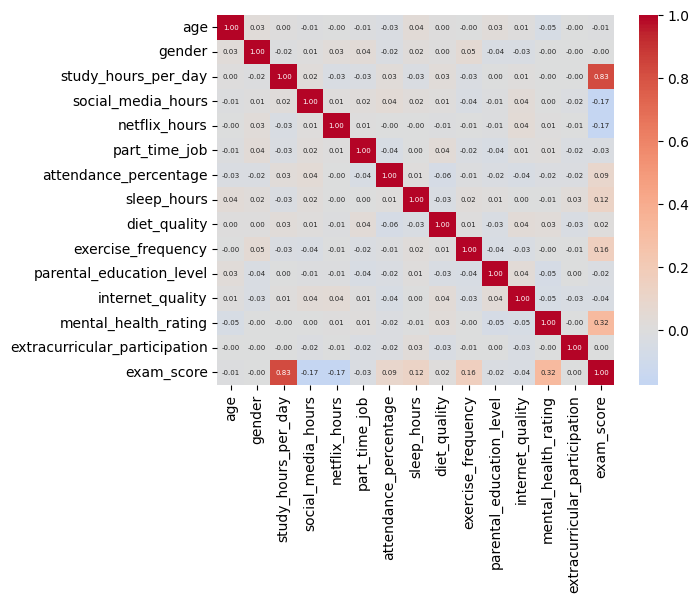

In [649]:
plot = sns.heatmap(df_revertido.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0, annot_kws={"size": 5})

A hipótese de que o estudo diário teria uma alta relação com a nota final manteve-se, sendo a maior correlação presente nos nossos dados. Porém, curiosamente, não temos correlações dos hábitos(por exemplo: exercício e saúde mental) no topo, então o contexto separado de saúde não demonstrou tanta força, tendo uma grande prevalencia de hábitos com a nota final.

Além disso, percebe-se que temos poucas correlações significativas, o que sustenta a hipótese de difcícil análise desse dataset devido à interrelação entre saúde e performance intelectual.

---

4) Algoritmo K-Means

De acordo com o livro Data Cience do Zero, o algoritmo K-Means pode ser resumido da seguinte forma:


1. Comece com um conjunto de k-means, que são pontos no
espaço d-dimensional;

2. Atribua cada ponto à média mais próxima dele;

3. Se não for alterada a atribuição de nenhum ponto, pare e
mantenha os grupos;

4. Se a atribuição de algum ponto for alterada, compute
novamente as médias e retorne à etapa 2

Vamos criar uma clase KMeans, semelhance à do sklearn, com nossas próprias funções:

Nota: referência utilisada: https://medium.com/@avijit.bhattacharjee1996/implementing-k-means-clustering-from-scratch-in-python-a277c23563ac

In [650]:
class KMeans:

    # define número de clusters e o máximo de iterações
    def __init__(self, n_clusters, max_itr):
        self.n_clusters = n_clusters
        self.max_itr = max_itr

    # função para encaixar cada ponto x no centroide mais próximo
    def _encaixar_centroides(self, X):
        labels = []
        for x in X:
            distancias = []
            for centroide in self.centroides:
                distancia = np.sqrt(np.sum((x - centroide) ** 2))
                distancias.append(distancia)

            indice_mais_proximo = np.argmin(distancias)
            labels.append(indice_mais_proximo)
        return np.array(labels)

    # função para atualizar os centróides com a média dos pontos
    def _update_centroides(self, X, labels):
        novos_centroides = []
        for i in range(self.n_clusters):
            pontos_do_cluster = X[labels == i]
            if len(pontos_do_cluster) > 0:
                novo_centroide = pontos_do_cluster.mean(axis=0)
                novos_centroides.append(novo_centroide)
            else:
                novo_centroide = X[np.random.randint(0, X.shape[0])]
                novos_centroides.append(novo_centroide)
        return np.array(novos_centroides)

    # lógica do KMeans
    def fit(self, X):
        self.centroides = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_itr):

            labels = self._encaixar_centroides(X)
            novos_centroides = self._update_centroides(X, labels)

            if np.all(self.centroides == novos_centroides):
                break
            
            self.centroides = novos_centroides
            
        self.labels = self._encaixar_centroides(X) 

        # calcular a inércia
        
        inercia_total = 0

        for i, centroide in enumerate(self.centroides):
            pontos_do_cluster = X[self.labels == i]
            distancias_ao_centroide = (pontos_do_cluster - centroide) ** 2
            soma_das_distancias = np.sum(distancias_ao_centroide)
            inercia_total += soma_das_distancias

        self.inercia = inercia_total

    

Agora, vams pegar o nosso fataframe numérico, escalado e imputado e testá-lo no modelo:

In [651]:
X = np.array(df_imputed)
X

array([[ 1.08455114, -0.97616309, -2.41806844, ...,  0.90018637,
         1.46446375, -0.7939222 ],
       [-0.21586989, -0.97616309,  2.28170684, ...,  0.90018637,
        -0.6828438 ,  1.80084647],
       [ 0.21760379,  0.76387807, -1.46449085, ..., -1.55933923,
        -0.6828438 , -2.09130653],
       ...,
       [-0.21586989,  0.76387807, -0.37468788, ...,  1.25154717,
         1.46446375, -0.30814359],
       [ 1.51802481,  0.76387807,  1.26001656, ..., -1.55933923,
        -0.6828438 ,  0.00583527],
       [-0.64934357, -0.97616309,  0.51077703, ...,  0.90018637,
        -0.6828438 ,  0.31388999]], shape=(1000, 15))

Porém, antes disso, qual K devemos escolher?

---
5) Definir o valor de K(n_clusters)

Para definir o número de clusters ideal, dentro da função fit() da classe KMeans foi criada uma variável que armazena a inércia das labels, assim podemos utilizar o método do cotovelo para ajudar a definir o K:

Nota: rodei o método do cotovelo 3 vezes para melhor análise das funções, que tinham uma leve mudança uma entre a outra

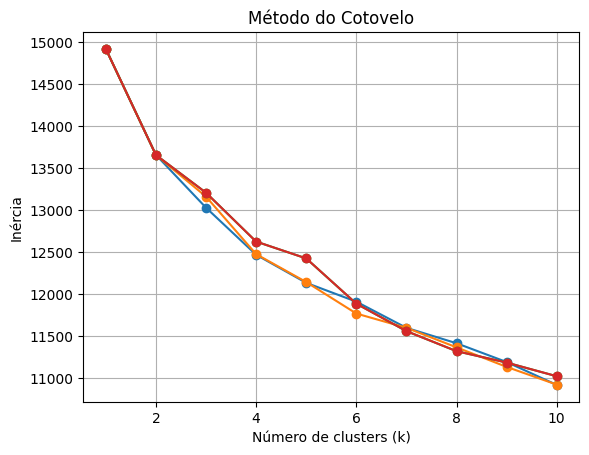

In [652]:
inercias_total = []

for experimento in range(3):
    inercias = []
    for k in range(1, 11): 
        modelo = KMeans(k, 100)  
        modelo.fit(X)
        inercias.append(modelo.inercia)
    inercias_total.append(inercias)
    plt.plot(range(1, 11), inercias, marker = 'o', label=f'Experimento {experimento+1}')

plt.plot(range(1, 11), inercias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.grid(True)

A partir desse gráfico, fica nítido a dobra nos pontos 3 e 4. Vamos tomar como k o número 3.

In [653]:
modelo = KMeans(n_clusters=3, max_itr=100)
modelo.fit(X)

---
6) Conclusão final

Agora que fizemos nossa clusterização, vamos analisar melhor a correlação dos nossos dados e como esses grupos se mostram nos gráficos:

In [654]:

df_revertido['cluster'] = modelo.labels
df_revertido['cluster'] = df_revertido['cluster'].astype('category')
df_revertido.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score,cluster
0,23.0,0.0,0.0,1.2,1.1,0,85.0,8.0,1.0,6.0,2,1.0,8.0,1.0,56.2,2
1,20.0,0.0,6.9,2.8,2.3,0,97.3,4.6,2.0,6.0,0,1.0,8.0,0.0,100.0,0
2,21.0,1.0,1.4,3.1,1.3,0,94.8,8.0,0.0,1.0,0,0.0,1.0,0.0,34.3,2
3,23.0,0.0,1.0,3.9,1.0,0,71.0,9.2,0.0,4.0,2,2.0,1.0,1.0,26.8,2
4,19.0,0.0,5.0,4.4,0.5,0,90.9,4.9,1.0,3.0,2,2.0,1.0,0.0,66.4,1


In [655]:
correlacao = df_revertido.corr()[['cluster']]
correlacao

,cluster
age,0.063457
gender,0.020838
study_hours_per_day,-0.607701
social_media_hours,0.082314
netflix_hours,0.128539
part_time_job,0.077544
attendance_percentage,-0.120744
sleep_hours,-0.117266
diet_quality,-0.071139
exercise_frequency,-0.050484


Ponto positivo: Features importantes (nota do exame, estudo diário e saúde mental) têm pesos altos. Faz sentido que alunos que estudam menos e têm saúde mental pior tenham notas menores. Dessa forma, clusters mais altos Cluster 1 parece representar alunos com:

1) Notas mais baixas (exam_score ↓).

2) Menos horas de estudo (study_hours_per_day ↓).

3) Saúde mental pior (mental_health_rating ↓).

4) Menos sono (sleep_hours ↓).

5) Mais tempo na Netflix (netflix_hours ↑).

6) Mais tempo nas redes sociais (social_media_hours ↑).

Ponto negativo: Não tivemos uma influência grande de qualidade de dieta, exercício, nem nivel de educação parental nos clusters, que também intuitivamente são features importantes em desempenho e saúde.

Vamos recuperar nossos centróides para plotar no gráfico(lembrando que ele está em escala!):

In [656]:
centroides_revertido = escala.inverse_transform(modelo.centroides)
centroides_revertido = pd.DataFrame(centroides_revertido, columns=df_numeric.columns)
centroides_revertido

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,20.039773,0.556818,4.328693,2.478693,1.740625,0.190341,85.397443,6.568466,1.295455,3.360795,0.643669,1.068182,7.750000,0.335227,83.297443
1,21.202128,0.535461,4.286879,2.282624,1.602128,0.180851,84.379787,6.656383,1.092199,2.553191,1.015704,1.560284,3.312057,0.258865,74.201418
2,20.396175,0.584699,2.233607,2.703005,2.063388,0.265027,82.723224,6.231967,1.172131,3.112022,0.654957,1.281421,4.852459,0.346995,52.885246


Agora, para uma análise inicial, vamos pegar o nosso par de features com maior correlação(estudo diário e notas finais) e ver como os clusters se comportam:

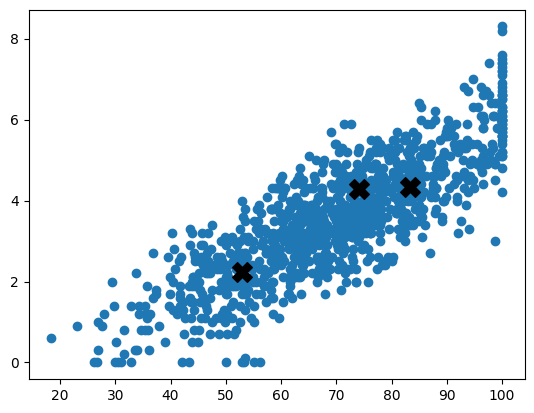

In [657]:
plt.scatter(df_revertido['exam_score'], df_revertido['study_hours_per_day'],)
plt.scatter(centroides_revertido['exam_score'], centroides_revertido['study_hours_per_day'], color='black', marker='X', s=200, label='Centroides')

Interessante, temos 3 clusters bem definidos em uma função semelhante à uma linear, mas para uma análise melhor o ideal seria poder conseguir combinar todas as features do dataset em dois eixos. Podemos tentar uma abordagem de criar dois eixos separados o contexto de performance e hábitos, e ver como ficam os dados nesse gráfico:

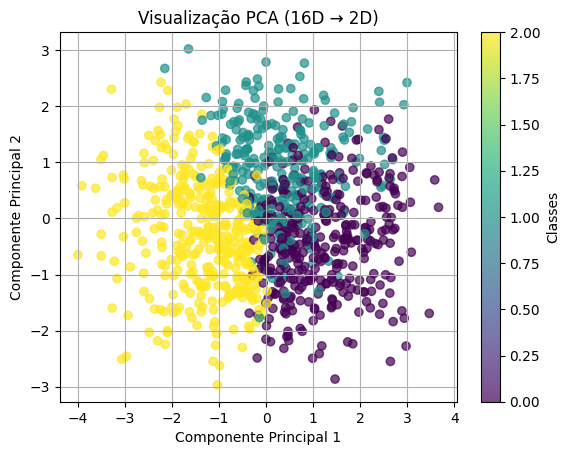

In [658]:
X = df_revertido.drop('cluster', axis=1)  
y = df_revertido['cluster']

escala = StandardScaler()
X_scaled = escala.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualização PCA (16D → 2D)')
plt.colorbar(scatter, label='Classes')
plt.grid(True)

Utilizando combinações lineares das features nos eixos para reduzir a dimensão dos dados, conseguimos uma visualização mais clara da separação ds clusters que nosso algoritmo proporcionou. Os grupos (classes) estão bem diferenciados no espaço reduzido, indicando que as 16 features originais contêm informações suficientes para distinguir os clusters. Vamos ver a contribuição das features nos componentes desse gráfico:

In [659]:
loadings = pd.DataFrame(pca.components_.T,  columns=['PC1', 'PC2'], index=X.columns)

print("Loadings (Contribuição das Features):")
print(loadings)

Loadings (Contribuição das Features):
                                    PC1       PC2
age                           -0.015172  0.140897
gender                        -0.012532 -0.383499
study_hours_per_day            0.615589  0.213857
social_media_hours            -0.114241  0.085886
netflix_hours                 -0.151385 -0.098665
part_time_job                 -0.043413 -0.311391
attendance_percentage          0.078462  0.144405
sleep_hours                    0.069873  0.031974
diet_quality                   0.030657 -0.186572
exercise_frequency             0.110755 -0.347907
parental_education_level      -0.033805  0.506143
internet_quality              -0.048168  0.309883
mental_health_rating           0.239161 -0.378046
extracurricular_participation  0.002057  0.020400
exam_score                     0.705620  0.000194


Tivemos grande contribuição das features já apontadas como mais correlacionadas com o cluster.

Conclusão final: 

Neste experimento, aplicamos o algoritmo de clusterização KMeans com o objetivo de agrupar estudantes com base em características relacionadas tanto à sua performance quanto aos seus hábitos/saúde.

Com o auxílio do método do cotovelo, identificamos que o número ideal de clusters era k = 3, o que indica a existência de três perfis distintos de estudantes no conjunto de dados.

A análise dos grupos revelou padrões comportamentais relevantes, como estudantes com alto comprometimento acadêmico (alto tempo de estudo e desempenho), um grupo intermediário, e um terceiro grupo com menor dedicação ou dificuldades no aprendizado. 

Portanto, a aplicação do KMeans se mostrou eficaz para segmentar os estudantes de maneira não supervisionada, gerando insights valiosos para a compreensão dos diferentes perfis presentes na amostra analisada. Porém, a influência de variáveis relacionadas à saúde física não foram tão presentes, o que cabe espaço para melhora.

Algumas ideias que podem melhorar o modelo posteriormente: 

1) Retirar algumas categorias da classificação;

2) Utilizar outros modelos que lidem melhor com grande número de features(por exemplo: DBSCAM);

3) Testar outros números de clusters K;

4) Engenharia de features(por exemplo: horas diárias redes socias x horas diárias netflix).

---
7) Algoritmos  DBSCAM e Hierarquical Clustering

---
8) Algoritmo State-of-the-art